In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install -q timm==0.9.16 fastervit>=0.9.8


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


In [4]:
import os
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from fastervit import create_model

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ---- experiment config for BASELINE ----
RUN_NAME = "fvit0_baseline_cifar10"
CHECKPOINT_DIR = Path("/kaggle/working") / RUN_NAME
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

NUM_CLASSES = 10
BATCH_SIZE = 128
NUM_EPOCHS = 75          # you asked for 75
BASE_LR = 5e-4
WEIGHT_DECAY = 0.05
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda


In [5]:
# standard CIFAR-10 transforms, resized to 224x224
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

data_root = "./data"

train_dataset = datasets.CIFAR10(
    root=data_root, train=True, download=True, transform=train_transform
)
test_dataset = datasets.CIFAR10(
    root=data_root, train=False, download=True, transform=test_transform
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=4, pin_memory=True
)

len(train_dataset), len(test_dataset)


100%|██████████| 170M/170M [00:06<00:00, 28.1MB/s] 


(50000, 10000)

In [6]:
def build_fvit0_baseline(pretrained_imagenet: bool = False) -> nn.Module:
    model = create_model(
        "faster_vit_0_224",
        pretrained=pretrained_imagenet,   # keep False for from-scratch CIFAR-10
        num_classes=NUM_CLASSES,
    )
    return model.to(DEVICE)

model = build_fvit0_baseline(pretrained_imagenet=False)
print("Baseline params (M):", sum(p.numel() for p in model.parameters()) / 1e6)


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Baseline params (M): 30.89697


In [7]:
def save_checkpoint(epoch, model, optimizer, scheduler, best_acc, path):
    state = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
        "best_acc": best_acc,
    }
    torch.save(state, path)
    print(f"[Checkpoint] Saved to {path}")


def load_checkpoint(path, model, optimizer=None, scheduler=None):
    print(f"[Checkpoint] Loading from {path}")
    ckpt = torch.load(path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    if optimizer is not None and "optimizer_state" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer_state"])
    if scheduler is not None and ckpt.get("scheduler_state") is not None:
        scheduler.load_state_dict(ckpt["scheduler_state"])
    start_epoch = ckpt.get("epoch", 0) + 1
    best_acc = ckpt.get("best_acc", 0.0)
    return start_epoch, best_acc


def train_one_epoch(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, targets in loader:
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"Train | Epoch {epoch} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, epoch, split="Val"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, targets in loader:
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"{split} | Epoch {epoch} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc


In [8]:
def run_training_baseline(resume: bool = True):
    model = build_fvit0_baseline(pretrained_imagenet=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY
    )
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    ckpt_path = CHECKPOINT_DIR / "latest.pt"
    best_path = CHECKPOINT_DIR / "best.pt"

    start_epoch = 0
    best_acc = 0.0

    # for curves
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # resume if checkpoint exists (same session)
    if resume and ckpt_path.exists():
        start_epoch, best_acc = load_checkpoint(
            ckpt_path, model, optimizer, scheduler
        )
        print(f"Resuming from epoch {start_epoch}, best_acc={best_acc:.2f}%")

    for epoch in range(start_epoch, NUM_EPOCHS):
        tl, ta = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
        vl, va = evaluate(model, test_loader, criterion, epoch, split="Val")

        train_losses.append(tl)
        train_accs.append(ta)
        val_losses.append(vl)
        val_accs.append(va)

        scheduler.step()

        # save latest every epoch
        save_checkpoint(epoch, model, optimizer, scheduler, best_acc, ckpt_path)

        # save best model
        if va > best_acc:
            best_acc = va
            save_checkpoint(epoch, model, optimizer, scheduler, best_acc, best_path)
            print(f"[Best] New best accuracy: {best_acc:.2f}% at epoch {epoch}")

    # save curves so you can compare with OCI later
    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "val_loss": val_losses,
        "val_acc": val_accs,
    }
    with open(CHECKPOINT_DIR / "training_history.json", "w") as f:
        json.dump(history, f, indent=2)

    print("Training finished. Best Val Acc: {:.2f}%".format(best_acc))


run_training_baseline(resume=True)


Train | Epoch 0 | Loss: 1.8019 | Acc: 31.26%
Val | Epoch 0 | Loss: 1.6393 | Acc: 39.62%
[Checkpoint] Saved to /kaggle/working/fvit0_baseline_cifar10/latest.pt
[Checkpoint] Saved to /kaggle/working/fvit0_baseline_cifar10/best.pt
[Best] New best accuracy: 39.62% at epoch 0
Train | Epoch 1 | Loss: 1.5116 | Acc: 44.25%
Val | Epoch 1 | Loss: 1.3147 | Acc: 51.67%
[Checkpoint] Saved to /kaggle/working/fvit0_baseline_cifar10/latest.pt
[Checkpoint] Saved to /kaggle/working/fvit0_baseline_cifar10/best.pt
[Best] New best accuracy: 51.67% at epoch 1
Train | Epoch 2 | Loss: 1.2323 | Acc: 55.79%
Val | Epoch 2 | Loss: 1.0845 | Acc: 61.55%
[Checkpoint] Saved to /kaggle/working/fvit0_baseline_cifar10/latest.pt
[Checkpoint] Saved to /kaggle/working/fvit0_baseline_cifar10/best.pt
[Best] New best accuracy: 61.55% at epoch 2
Train | Epoch 3 | Loss: 1.1367 | Acc: 59.80%
Val | Epoch 3 | Loss: 1.0761 | Acc: 60.98%
[Checkpoint] Saved to /kaggle/working/fvit0_baseline_cifar10/latest.pt
Train | Epoch 4 | Loss: 1

In [10]:
import json

BEST_CKPT_BASE = CHECKPOINT_DIR / "best.pt"
print("Baseline best checkpoint path:", BEST_CKPT_BASE)

# rebuild baseline model & load best weights
model_base = build_fvit0_baseline(pretrained_imagenet=False)
criterion = nn.CrossEntropyLoss()

start_epoch_base, best_acc_saved_base = load_checkpoint(
    BEST_CKPT_BASE,
    model_base,
    optimizer=None,
    scheduler=None,
)

print(f"[Baseline] Best val acc from ckpt: {best_acc_saved_base:.2f}% (epoch {start_epoch_base-1})")

# final TEST evaluation
test_loss_base, test_acc_base = evaluate(
    model_base,
    test_loader,
    criterion,
    epoch="best",
    split="Test (Baseline)"
)

print(f"[FasterViT-0 BASELINE] Final Test Acc: {test_acc_base:.2f}%, Test Loss: {test_loss_base:.4f}")

# save numeric results
results_base = {
    "model": "fvit0_baseline_cifar10",
    "ckpt_epoch": int(start_epoch_base - 1),
    "val_best_acc": float(best_acc_saved_base),
    "test_loss": float(test_loss_base),
    "test_acc": float(test_acc_base),
}

results_path_base = CHECKPOINT_DIR / "results_baseline.json"
with open(results_path_base, "w") as f:
    json.dump(results_base, f, indent=2)

print("Saved baseline results to", results_path_base)


Baseline best checkpoint path: /kaggle/working/fvit0_baseline_cifar10/best.pt
[Checkpoint] Loading from /kaggle/working/fvit0_baseline_cifar10/best.pt
[Baseline] Best val acc from ckpt: 91.47% (epoch 72)
Test (Baseline) | Epoch best | Loss: 0.3180 | Acc: 91.47%
[FasterViT-0 BASELINE] Final Test Acc: 91.47%, Test Loss: 0.3180
Saved baseline results to /kaggle/working/fvit0_baseline_cifar10/results_baseline.json


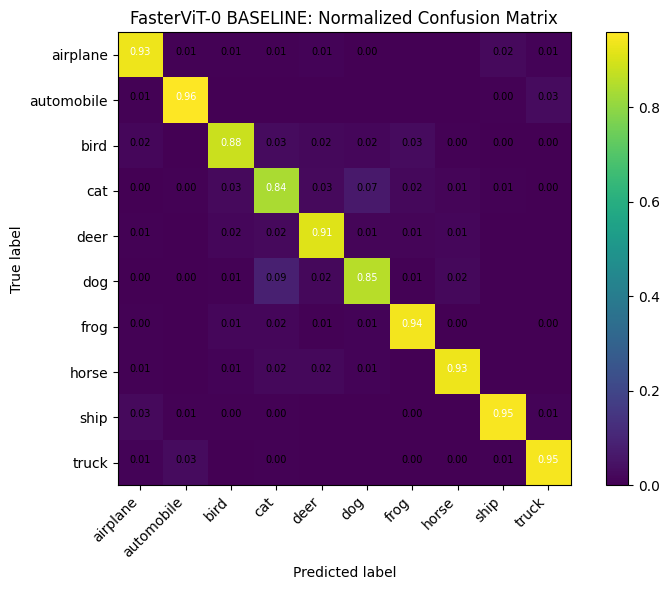

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

model_base.eval()
model_base.to(DEVICE)

all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model_base(images)
        _, preds = outputs.max(1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

cm = confusion_matrix(all_targets, all_preds)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

classes = train_dataset.classes  # CIFAR-10 labels

plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, interpolation='nearest')
plt.title("FasterViT-0 BASELINE: Normalized Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha="right")
plt.yticks(tick_marks, classes)

thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    val = cm_norm[i, j]
    if val > 0.001:
        plt.text(j, i, f"{val:.2f}",
                 horizontalalignment="center",
                 color="white" if val > thresh else "black",
                 fontsize=7)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


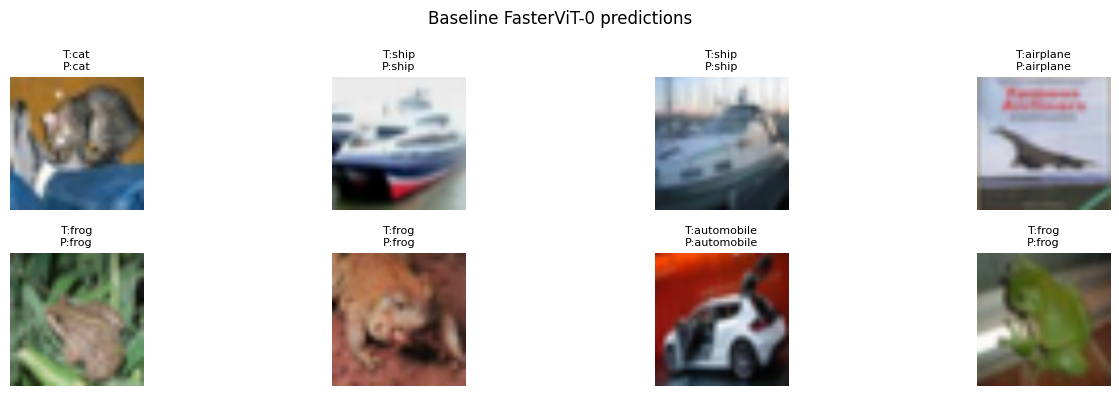

In [12]:
def show_examples(model, loader, n=8, title_prefix="Baseline"):
    model.eval()
    images, targets = next(iter(loader))
    images, targets = images.to(DEVICE), targets.to(DEVICE)

    with torch.no_grad():
        outputs = model(images)
        _, preds = outputs.max(1)

    images = images.cpu()
    preds = preds.cpu()
    targets = targets.cpu()

    classes = train_dataset.classes
    plt.figure(figsize=(14, 4))
    for i in range(n):
        img = images[i]
        # un-normalize for display
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        img = img + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        plt.subplot(2, n//2, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"T:{classes[targets[i]]}\nP:{classes[preds[i]]}", fontsize=8)

    plt.suptitle(f"{title_prefix} predictions", fontsize=12)
    plt.tight_layout()
    plt.show()

show_examples(model_base, test_loader, n=8, title_prefix="Baseline FasterViT-0")


In [13]:
import time

def measure_throughput(model, batch_size=128, img_size=224, steps=50, warmup=10):
    model.eval()
    model.to(DEVICE)
    dummy = torch.randn(batch_size, 3, img_size, img_size).to(DEVICE)

    # warmup
    for _ in range(warmup):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t0 = time.time()

    for _ in range(steps):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t1 = time.time()

    total_images = batch_size * steps
    throughput = total_images / (t1 - t0)
    return throughput


def measure_latency(model, img_size=224, warmup=10, runs=100):
    model.eval()
    model.to(DEVICE)
    dummy = torch.randn(1, 3, img_size, img_size).to(DEVICE)

    # warmup
    for _ in range(warmup):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t_start = time.time()

    for _ in range(runs):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t_end = time.time()

    latency_ms = (t_end - t_start) / runs * 1000
    return latency_ms

throughput_base = measure_throughput(model_base)
latency_base = measure_latency(model_base)

print(f"[Baseline] Throughput: {throughput_base:.2f} imgs/sec")
print(f"[Baseline] Latency: {latency_base:.4f} ms/image")

[Baseline] Throughput: 790.79 imgs/sec
[Baseline] Latency: 26.6586 ms/image


In [14]:
import shutil

zip_base = Path("/kaggle/working") / f"{RUN_NAME}_artifacts"
zip_path = shutil.make_archive(
    base_name=str(zip_base),
    format="zip",
    root_dir=CHECKPOINT_DIR,
)
print("Created zip:", zip_path)


Created zip: /kaggle/working/fvit0_baseline_cifar10_artifacts.zip


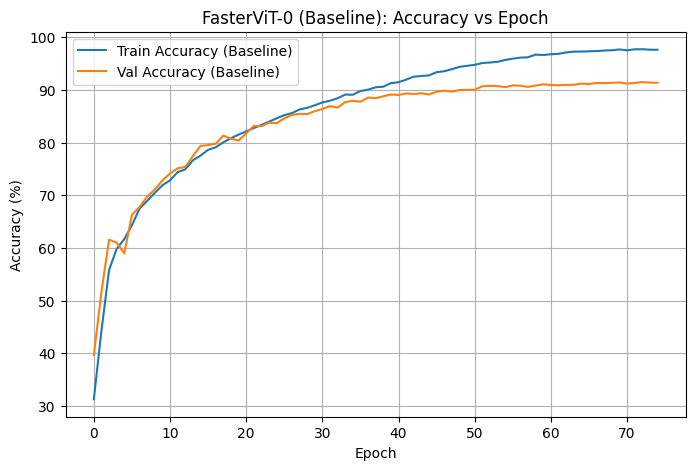

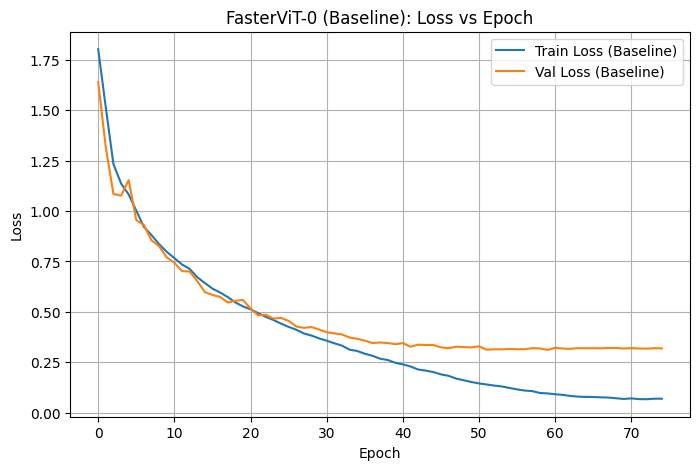

In [15]:
import re
import matplotlib.pyplot as plt

log_base = """
Train | Epoch 0 | Loss: 1.8019 | Acc: 31.26%
Val | Epoch 0 | Loss: 1.6393 | Acc: 39.62%
Train | Epoch 1 | Loss: 1.5116 | Acc: 44.25%
Val | Epoch 1 | Loss: 1.3147 | Acc: 51.67%
Train | Epoch 2 | Loss: 1.2323 | Acc: 55.79%
Val | Epoch 2 | Loss: 1.0845 | Acc: 61.55%
Train | Epoch 3 | Loss: 1.1367 | Acc: 59.80%
Val | Epoch 3 | Loss: 1.0761 | Acc: 60.98%
Train | Epoch 4 | Loss: 1.0821 | Acc: 61.66%
Val | Epoch 4 | Loss: 1.1531 | Acc: 58.94%
Train | Epoch 5 | Loss: 1.0019 | Acc: 64.28%
Val | Epoch 5 | Loss: 0.9551 | Acc: 66.28%
Train | Epoch 6 | Loss: 0.9213 | Acc: 67.46%
Val | Epoch 6 | Loss: 0.9306 | Acc: 67.75%
Train | Epoch 7 | Loss: 0.8806 | Acc: 68.90%
Val | Epoch 7 | Loss: 0.8548 | Acc: 69.73%
Train | Epoch 8 | Loss: 0.8354 | Acc: 70.44%
Val | Epoch 8 | Loss: 0.8253 | Acc: 71.07%
Train | Epoch 9 | Loss: 0.7978 | Acc: 71.88%
Val | Epoch 9 | Loss: 0.7701 | Acc: 72.81%
Train | Epoch 10 | Loss: 0.7668 | Acc: 72.81%
Val | Epoch 10 | Loss: 0.7439 | Acc: 74.10%
Train | Epoch 11 | Loss: 0.7351 | Acc: 74.38%
Val | Epoch 11 | Loss: 0.7018 | Acc: 75.11%
Train | Epoch 12 | Loss: 0.7132 | Acc: 74.89%
Val | Epoch 12 | Loss: 0.7005 | Acc: 75.35%
Train | Epoch 13 | Loss: 0.6723 | Acc: 76.62%
Val | Epoch 13 | Loss: 0.6531 | Acc: 77.41%
Train | Epoch 14 | Loss: 0.6432 | Acc: 77.50%
Val | Epoch 14 | Loss: 0.5982 | Acc: 79.37%
Train | Epoch 15 | Loss: 0.6155 | Acc: 78.61%
Val | Epoch 15 | Loss: 0.5842 | Acc: 79.49%
Train | Epoch 16 | Loss: 0.5960 | Acc: 79.09%
Val | Epoch 16 | Loss: 0.5744 | Acc: 79.76%
Train | Epoch 17 | Loss: 0.5738 | Acc: 80.04%
Val | Epoch 17 | Loss: 0.5466 | Acc: 81.30%
Train | Epoch 18 | Loss: 0.5471 | Acc: 80.81%
Val | Epoch 18 | Loss: 0.5552 | Acc: 80.73%
Train | Epoch 19 | Loss: 0.5275 | Acc: 81.50%
Val | Epoch 19 | Loss: 0.5594 | Acc: 80.38%
Train | Epoch 20 | Loss: 0.5128 | Acc: 82.11%
Val | Epoch 20 | Loss: 0.5171 | Acc: 81.73%
Train | Epoch 21 | Loss: 0.4938 | Acc: 82.73%
Val | Epoch 21 | Loss: 0.4827 | Acc: 83.15%
Train | Epoch 22 | Loss: 0.4756 | Acc: 83.34%
Val | Epoch 22 | Loss: 0.4859 | Acc: 83.09%
Train | Epoch 23 | Loss: 0.4600 | Acc: 83.95%
Val | Epoch 23 | Loss: 0.4672 | Acc: 83.76%
Train | Epoch 24 | Loss: 0.4419 | Acc: 84.59%
Val | Epoch 24 | Loss: 0.4703 | Acc: 83.67%
Train | Epoch 25 | Loss: 0.4258 | Acc: 85.19%
Val | Epoch 25 | Loss: 0.4556 | Acc: 84.58%
Train | Epoch 26 | Loss: 0.4118 | Acc: 85.58%
Val | Epoch 26 | Loss: 0.4278 | Acc: 85.24%
Train | Epoch 27 | Loss: 0.3932 | Acc: 86.27%
Val | Epoch 27 | Loss: 0.4211 | Acc: 85.45%
Train | Epoch 28 | Loss: 0.3828 | Acc: 86.57%
Val | Epoch 28 | Loss: 0.4251 | Acc: 85.39%
Train | Epoch 29 | Loss: 0.3687 | Acc: 87.06%
Val | Epoch 29 | Loss: 0.4127 | Acc: 85.95%
Train | Epoch 30 | Loss: 0.3575 | Acc: 87.61%
Val | Epoch 30 | Loss: 0.3994 | Acc: 86.38%
Train | Epoch 31 | Loss: 0.3444 | Acc: 87.93%
Val | Epoch 31 | Loss: 0.3937 | Acc: 86.91%
Train | Epoch 32 | Loss: 0.3330 | Acc: 88.40%
Val | Epoch 32 | Loss: 0.3882 | Acc: 86.62%
Train | Epoch 33 | Loss: 0.3128 | Acc: 89.10%
Val | Epoch 33 | Loss: 0.3730 | Acc: 87.68%
Train | Epoch 34 | Loss: 0.3065 | Acc: 89.07%
Val | Epoch 34 | Loss: 0.3667 | Acc: 87.91%
Train | Epoch 35 | Loss: 0.2927 | Acc: 89.77%
Val | Epoch 35 | Loss: 0.3577 | Acc: 87.73%
Train | Epoch 36 | Loss: 0.2826 | Acc: 90.03%
Val | Epoch 36 | Loss: 0.3457 | Acc: 88.54%
Train | Epoch 37 | Loss: 0.2683 | Acc: 90.48%
Val | Epoch 37 | Loss: 0.3483 | Acc: 88.41%
Train | Epoch 38 | Loss: 0.2617 | Acc: 90.59%
Val | Epoch 38 | Loss: 0.3461 | Acc: 88.78%
Train | Epoch 39 | Loss: 0.2482 | Acc: 91.27%
Val | Epoch 39 | Loss: 0.3399 | Acc: 89.11%
Train | Epoch 40 | Loss: 0.2400 | Acc: 91.44%
Val | Epoch 40 | Loss: 0.3454 | Acc: 89.03%
Train | Epoch 41 | Loss: 0.2296 | Acc: 91.93%
Val | Epoch 41 | Loss: 0.3276 | Acc: 89.32%
Train | Epoch 42 | Loss: 0.2146 | Acc: 92.50%
Val | Epoch 42 | Loss: 0.3377 | Acc: 89.22%
Train | Epoch 43 | Loss: 0.2090 | Acc: 92.62%
Val | Epoch 43 | Loss: 0.3359 | Acc: 89.35%
Train | Epoch 44 | Loss: 0.2019 | Acc: 92.74%
Val | Epoch 44 | Loss: 0.3358 | Acc: 89.10%
Train | Epoch 45 | Loss: 0.1904 | Acc: 93.35%
Val | Epoch 45 | Loss: 0.3245 | Acc: 89.65%
Train | Epoch 46 | Loss: 0.1833 | Acc: 93.53%
Val | Epoch 46 | Loss: 0.3198 | Acc: 89.84%
Train | Epoch 47 | Loss: 0.1696 | Acc: 93.92%
Val | Epoch 47 | Loss: 0.3276 | Acc: 89.66%
Train | Epoch 48 | Loss: 0.1610 | Acc: 94.36%
Val | Epoch 48 | Loss: 0.3257 | Acc: 89.96%
Train | Epoch 49 | Loss: 0.1526 | Acc: 94.56%
Val | Epoch 49 | Loss: 0.3241 | Acc: 90.00%
Train | Epoch 50 | Loss: 0.1456 | Acc: 94.75%
Val | Epoch 50 | Loss: 0.3296 | Acc: 90.01%
Train | Epoch 51 | Loss: 0.1403 | Acc: 95.09%
Val | Epoch 51 | Loss: 0.3130 | Acc: 90.68%
Train | Epoch 52 | Loss: 0.1349 | Acc: 95.19%
Val | Epoch 52 | Loss: 0.3145 | Acc: 90.76%
Train | Epoch 53 | Loss: 0.1306 | Acc: 95.32%
Val | Epoch 53 | Loss: 0.3145 | Acc: 90.72%
Train | Epoch 54 | Loss: 0.1232 | Acc: 95.67%
Val | Epoch 54 | Loss: 0.3163 | Acc: 90.50%
Train | Epoch 55 | Loss: 0.1158 | Acc: 95.92%
Val | Epoch 55 | Loss: 0.3150 | Acc: 90.84%
Train | Epoch 56 | Loss: 0.1103 | Acc: 96.11%
Val | Epoch 56 | Loss: 0.3153 | Acc: 90.79%
Train | Epoch 57 | Loss: 0.1074 | Acc: 96.18%
Val | Epoch 57 | Loss: 0.3204 | Acc: 90.55%
Train | Epoch 58 | Loss: 0.0981 | Acc: 96.69%
Val | Epoch 58 | Loss: 0.3186 | Acc: 90.82%
Train | Epoch 59 | Loss: 0.0962 | Acc: 96.61%
Val | Epoch 59 | Loss: 0.3118 | Acc: 91.05%
Train | Epoch 60 | Loss: 0.0919 | Acc: 96.75%
Val | Epoch 60 | Loss: 0.3218 | Acc: 90.91%
Train | Epoch 61 | Loss: 0.0888 | Acc: 96.84%
Val | Epoch 61 | Loss: 0.3185 | Acc: 90.88%
Train | Epoch 62 | Loss: 0.0833 | Acc: 97.10%
Val | Epoch 62 | Loss: 0.3170 | Acc: 90.94%
Train | Epoch 63 | Loss: 0.0801 | Acc: 97.25%
Val | Epoch 63 | Loss: 0.3203 | Acc: 90.95%
Train | Epoch 64 | Loss: 0.0788 | Acc: 97.27%
Val | Epoch 64 | Loss: 0.3198 | Acc: 91.18%
Train | Epoch 65 | Loss: 0.0782 | Acc: 97.31%
Val | Epoch 65 | Loss: 0.3201 | Acc: 91.11%
Train | Epoch 66 | Loss: 0.0766 | Acc: 97.36%
Val | Epoch 66 | Loss: 0.3195 | Acc: 91.31%
Train | Epoch 67 | Loss: 0.0755 | Acc: 97.46%
Val | Epoch 67 | Loss: 0.3215 | Acc: 91.29%
Train | Epoch 68 | Loss: 0.0721 | Acc: 97.51%
Val | Epoch 68 | Loss: 0.3211 | Acc: 91.33%
Train | Epoch 69 | Loss: 0.0686 | Acc: 97.67%
Val | Epoch 69 | Loss: 0.3188 | Acc: 91.40%
Train | Epoch 70 | Loss: 0.0714 | Acc: 97.50%
Val | Epoch 70 | Loss: 0.3203 | Acc: 91.19%
Train | Epoch 71 | Loss: 0.0679 | Acc: 97.69%
Val | Epoch 71 | Loss: 0.3187 | Acc: 91.30%
Train | Epoch 72 | Loss: 0.0673 | Acc: 97.71%
Val | Epoch 72 | Loss: 0.3180 | Acc: 91.47%
Train | Epoch 73 | Loss: 0.0699 | Acc: 97.62%
Val | Epoch 73 | Loss: 0.3203 | Acc: 91.37%
Train | Epoch 74 | Loss: 0.0699 | Acc: 97.61%
Val | Epoch 74 | Loss: 0.3192 | Acc: 91.33%
"""

train_loss, train_acc = [], []
val_loss, val_acc = [], []

for line in log_base.splitlines():
    line = line.strip()
    m_train = re.match(r"Train \| Epoch (\d+) \| Loss: ([0-9.]+) \| Acc: ([0-9.]+)%", line)
    m_val   = re.match(r"Val \| Epoch (\d+) \| Loss: ([0-9.]+) \| Acc: ([0-9.]+)%", line)

    if m_train:
        epoch = int(m_train.group(1))
        loss = float(m_train.group(2))
        acc  = float(m_train.group(3))
        while len(train_loss) <= epoch:
            train_loss.append(None)
            train_acc.append(None)
        train_loss[epoch] = loss
        train_acc[epoch] = acc

    if m_val:
        epoch = int(m_val.group(1))
        loss = float(m_val.group(2))
        acc  = float(m_val.group(3))
        while len(val_loss) <= epoch:
            val_loss.append(None)
            val_acc.append(None)
        val_loss[epoch] = loss
        val_acc[epoch] = acc

epochs = range(len(train_loss))

# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Train Accuracy (Baseline)")
plt.plot(epochs, val_acc,   label="Val Accuracy (Baseline)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("FasterViT-0 (Baseline): Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Train Loss (Baseline)")
plt.plot(epochs, val_loss,   label="Val Loss (Baseline)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("FasterViT-0 (Baseline): Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()


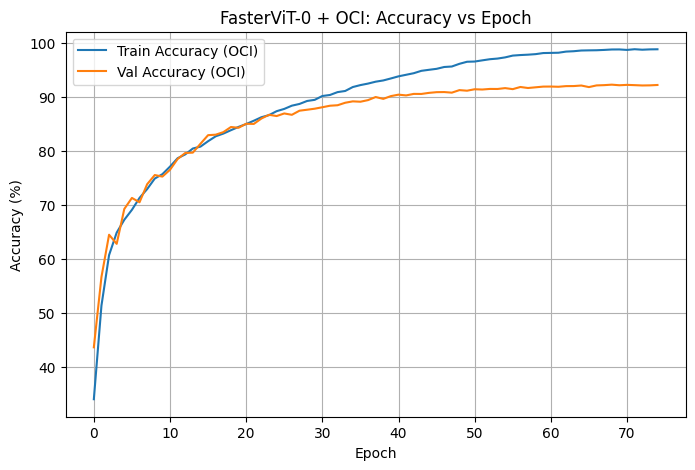

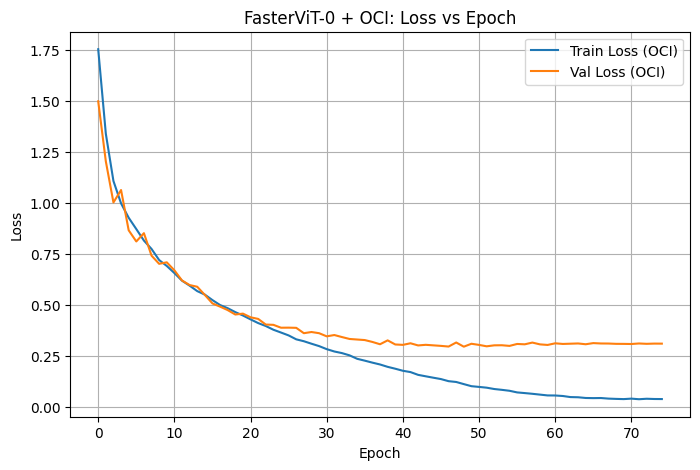

In [16]:
import re
import matplotlib.pyplot as plt

# ====== 1. Paste your OCI training log here ======
log_oci = """
[OCI] Patching carrier conv in 'levels.2.global_tokenizer'
[OCI] Total carrier initializers patched: 1
Train | Epoch 0 | Loss: 1.7523 | Acc: 34.04%
Val | Epoch 0 | Loss: 1.4970 | Acc: 43.65%
Train | Epoch 1 | Loss: 1.3378 | Acc: 51.37%
Val | Epoch 1 | Loss: 1.2024 | Acc: 56.66%
Train | Epoch 2 | Loss: 1.1060 | Acc: 60.72%
Val | Epoch 2 | Loss: 1.0008 | Acc: 64.49%
Train | Epoch 3 | Loss: 0.9963 | Acc: 64.88%
Val | Epoch 3 | Loss: 1.0618 | Acc: 62.80%
Train | Epoch 4 | Loss: 0.9259 | Acc: 67.26%
Val | Epoch 4 | Loss: 0.8643 | Acc: 69.26%
Train | Epoch 5 | Loss: 0.8703 | Acc: 69.10%
Val | Epoch 5 | Loss: 0.8095 | Acc: 71.30%
Train | Epoch 6 | Loss: 0.8139 | Acc: 71.31%
Val | Epoch 6 | Loss: 0.8502 | Acc: 70.50%
Train | Epoch 7 | Loss: 0.7728 | Acc: 72.94%
Val | Epoch 7 | Loss: 0.7400 | Acc: 73.84%
Train | Epoch 8 | Loss: 0.7184 | Acc: 74.89%
Val | Epoch 8 | Loss: 0.6998 | Acc: 75.54%
Train | Epoch 9 | Loss: 0.6894 | Acc: 75.70%
Val | Epoch 9 | Loss: 0.7072 | Acc: 75.25%
Train | Epoch 10 | Loss: 0.6546 | Acc: 77.10%
Val | Epoch 10 | Loss: 0.6682 | Acc: 76.51%
Train | Epoch 11 | Loss: 0.6172 | Acc: 78.65%
Val | Epoch 11 | Loss: 0.6181 | Acc: 78.51%
Train | Epoch 12 | Loss: 0.5928 | Acc: 79.36%
Val | Epoch 12 | Loss: 0.5957 | Acc: 79.62%
Train | Epoch 13 | Loss: 0.5660 | Acc: 80.45%
Val | Epoch 13 | Loss: 0.5874 | Acc: 79.69%
Train | Epoch 14 | Loss: 0.5488 | Acc: 80.80%
Val | Epoch 14 | Loss: 0.5473 | Acc: 81.33%
Train | Epoch 15 | Loss: 0.5219 | Acc: 81.80%
Val | Epoch 15 | Loss: 0.5055 | Acc: 82.92%
Train | Epoch 16 | Loss: 0.4977 | Acc: 82.71%
Val | Epoch 16 | Loss: 0.4899 | Acc: 83.01%
Train | Epoch 17 | Loss: 0.4822 | Acc: 83.21%
Val | Epoch 17 | Loss: 0.4729 | Acc: 83.48%
Train | Epoch 18 | Loss: 0.4630 | Acc: 83.84%
Val | Epoch 18 | Loss: 0.4512 | Acc: 84.43%
Train | Epoch 19 | Loss: 0.4464 | Acc: 84.45%
Val | Epoch 19 | Loss: 0.4556 | Acc: 84.29%
Train | Epoch 20 | Loss: 0.4274 | Acc: 84.98%
Val | Epoch 20 | Loss: 0.4376 | Acc: 85.03%
Train | Epoch 21 | Loss: 0.4092 | Acc: 85.59%
Val | Epoch 21 | Loss: 0.4297 | Acc: 85.00%
Train | Epoch 22 | Loss: 0.3948 | Acc: 86.24%
Val | Epoch 22 | Loss: 0.4020 | Acc: 86.00%
Train | Epoch 23 | Loss: 0.3766 | Acc: 86.63%
Val | Epoch 23 | Loss: 0.4006 | Acc: 86.69%
Train | Epoch 24 | Loss: 0.3628 | Acc: 87.36%
Val | Epoch 24 | Loss: 0.3865 | Acc: 86.46%
Train | Epoch 25 | Loss: 0.3487 | Acc: 87.78%
Val | Epoch 25 | Loss: 0.3868 | Acc: 86.94%
Train | Epoch 26 | Loss: 0.3295 | Acc: 88.38%
Val | Epoch 26 | Loss: 0.3859 | Acc: 86.69%
Train | Epoch 27 | Loss: 0.3202 | Acc: 88.70%
Val | Epoch 27 | Loss: 0.3596 | Acc: 87.45%
Train | Epoch 28 | Loss: 0.3080 | Acc: 89.25%
Val | Epoch 28 | Loss: 0.3654 | Acc: 87.63%
Train | Epoch 29 | Loss: 0.2963 | Acc: 89.46%
Val | Epoch 29 | Loss: 0.3596 | Acc: 87.82%
Train | Epoch 30 | Loss: 0.2814 | Acc: 90.17%
Val | Epoch 30 | Loss: 0.3442 | Acc: 88.09%
Train | Epoch 31 | Loss: 0.2699 | Acc: 90.36%
Val | Epoch 31 | Loss: 0.3506 | Acc: 88.37%
Train | Epoch 32 | Loss: 0.2620 | Acc: 90.89%
Val | Epoch 32 | Loss: 0.3407 | Acc: 88.46%
Train | Epoch 33 | Loss: 0.2509 | Acc: 91.10%
Val | Epoch 33 | Loss: 0.3313 | Acc: 88.92%
Train | Epoch 34 | Loss: 0.2340 | Acc: 91.83%
Val | Epoch 34 | Loss: 0.3286 | Acc: 89.18%
Train | Epoch 35 | Loss: 0.2249 | Acc: 92.19%
Val | Epoch 35 | Loss: 0.3259 | Acc: 89.11%
Train | Epoch 36 | Loss: 0.2152 | Acc: 92.47%
Val | Epoch 36 | Loss: 0.3167 | Acc: 89.41%
Train | Epoch 37 | Loss: 0.2062 | Acc: 92.82%
Val | Epoch 37 | Loss: 0.3054 | Acc: 89.98%
Train | Epoch 38 | Loss: 0.1946 | Acc: 93.05%
Val | Epoch 38 | Loss: 0.3244 | Acc: 89.64%
Train | Epoch 39 | Loss: 0.1854 | Acc: 93.42%
Val | Epoch 39 | Loss: 0.3043 | Acc: 90.15%
Train | Epoch 40 | Loss: 0.1753 | Acc: 93.81%
Val | Epoch 40 | Loss: 0.3024 | Acc: 90.42%
Train | Epoch 41 | Loss: 0.1689 | Acc: 94.10%
Val | Epoch 41 | Loss: 0.3102 | Acc: 90.28%
Train | Epoch 42 | Loss: 0.1553 | Acc: 94.39%
Val | Epoch 42 | Loss: 0.2996 | Acc: 90.56%
Train | Epoch 43 | Loss: 0.1482 | Acc: 94.83%
Val | Epoch 43 | Loss: 0.3026 | Acc: 90.55%
Train | Epoch 44 | Loss: 0.1413 | Acc: 95.02%
Val | Epoch 44 | Loss: 0.3000 | Acc: 90.75%
Train | Epoch 45 | Loss: 0.1346 | Acc: 95.20%
Val | Epoch 45 | Loss: 0.2974 | Acc: 90.88%
Train | Epoch 46 | Loss: 0.1243 | Acc: 95.54%
Val | Epoch 46 | Loss: 0.2941 | Acc: 90.90%
Train | Epoch 47 | Loss: 0.1204 | Acc: 95.63%
Val | Epoch 47 | Loss: 0.3140 | Acc: 90.79%
Train | Epoch 48 | Loss: 0.1099 | Acc: 96.13%
Val | Epoch 48 | Loss: 0.2935 | Acc: 91.26%
Train | Epoch 49 | Loss: 0.0997 | Acc: 96.51%
Val | Epoch 49 | Loss: 0.3078 | Acc: 91.15%
Train | Epoch 50 | Loss: 0.0962 | Acc: 96.55%
Val | Epoch 50 | Loss: 0.3022 | Acc: 91.42%
Train | Epoch 51 | Loss: 0.0924 | Acc: 96.77%
Val | Epoch 51 | Loss: 0.2953 | Acc: 91.37%
Train | Epoch 52 | Loss: 0.0858 | Acc: 96.98%
Val | Epoch 52 | Loss: 0.3001 | Acc: 91.48%
Train | Epoch 53 | Loss: 0.0818 | Acc: 97.10%
Val | Epoch 53 | Loss: 0.3005 | Acc: 91.47%
Train | Epoch 54 | Loss: 0.0772 | Acc: 97.32%
Val | Epoch 54 | Loss: 0.2973 | Acc: 91.63%
Train | Epoch 55 | Loss: 0.0692 | Acc: 97.65%
Val | Epoch 55 | Loss: 0.3068 | Acc: 91.44%
Train | Epoch 56 | Loss: 0.0659 | Acc: 97.75%
Val | Epoch 56 | Loss: 0.3051 | Acc: 91.84%
Train | Epoch 57 | Loss: 0.0624 | Acc: 97.82%
Val | Epoch 57 | Loss: 0.3136 | Acc: 91.65%
Train | Epoch 58 | Loss: 0.0584 | Acc: 97.92%
Val | Epoch 58 | Loss: 0.3048 | Acc: 91.78%
Train | Epoch 59 | Loss: 0.0544 | Acc: 98.12%
Val | Epoch 59 | Loss: 0.3020 | Acc: 91.91%
Train | Epoch 60 | Loss: 0.0541 | Acc: 98.15%
Val | Epoch 60 | Loss: 0.3100 | Acc: 91.92%
Train | Epoch 61 | Loss: 0.0516 | Acc: 98.18%
Val | Epoch 61 | Loss: 0.3069 | Acc: 91.88%
Train | Epoch 62 | Loss: 0.0463 | Acc: 98.39%
Val | Epoch 62 | Loss: 0.3081 | Acc: 92.00%
Train | Epoch 63 | Loss: 0.0454 | Acc: 98.46%
Val | Epoch 63 | Loss: 0.3093 | Acc: 92.01%
Train | Epoch 64 | Loss: 0.0419 | Acc: 98.59%
Val | Epoch 64 | Loss: 0.3054 | Acc: 92.11%
Train | Epoch 65 | Loss: 0.0412 | Acc: 98.62%
Val | Epoch 65 | Loss: 0.3110 | Acc: 91.82%
Train | Epoch 66 | Loss: 0.0417 | Acc: 98.64%
Val | Epoch 66 | Loss: 0.3092 | Acc: 92.13%
Train | Epoch 67 | Loss: 0.0388 | Acc: 98.70%
Val | Epoch 67 | Loss: 0.3089 | Acc: 92.18%
Train | Epoch 68 | Loss: 0.0374 | Acc: 98.78%
Val | Epoch 68 | Loss: 0.3074 | Acc: 92.27%
Train | Epoch 69 | Loss: 0.0364 | Acc: 98.79%
Val | Epoch 69 | Loss: 0.3072 | Acc: 92.16%
Train | Epoch 70 | Loss: 0.0387 | Acc: 98.70%
Val | Epoch 70 | Loss: 0.3066 | Acc: 92.23%
Train | Epoch 71 | Loss: 0.0358 | Acc: 98.83%
Val | Epoch 71 | Loss: 0.3092 | Acc: 92.18%
Train | Epoch 72 | Loss: 0.0381 | Acc: 98.74%
Val | Epoch 72 | Loss: 0.3075 | Acc: 92.12%
Train | Epoch 73 | Loss: 0.0369 | Acc: 98.80%
Val | Epoch 73 | Loss: 0.3086 | Acc: 92.14%
Train | Epoch 74 | Loss: 0.0366 | Acc: 98.82%
Val | Epoch 74 | Loss: 0.3084 | Acc: 92.21%
Training finished. Best Val Acc: 92.27%
"""

# ====== 2. Parse log ======
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for line in log_oci.splitlines():
    line = line.strip()
    m_train = re.match(r"Train \| Epoch (\d+) \| Loss: ([0-9.]+) \| Acc: ([0-9.]+)%", line)
    m_val   = re.match(r"Val \| Epoch (\d+) \| Loss: ([0-9.]+) \| Acc: ([0-9.]+)%", line)

    if m_train:
        epoch = int(m_train.group(1))
        loss = float(m_train.group(2))
        acc  = float(m_train.group(3))
        while len(train_loss) <= epoch:
            train_loss.append(None)
            train_acc.append(None)
        train_loss[epoch] = loss
        train_acc[epoch] = acc

    if m_val:
        epoch = int(m_val.group(1))
        loss = float(m_val.group(2))
        acc  = float(m_val.group(3))
        while len(val_loss) <= epoch:
            val_loss.append(None)
            val_acc.append(None)
        val_loss[epoch] = loss
        val_acc[epoch] = acc

epochs = range(len(train_loss))

# ====== 3. Accuracy vs Epoch ======
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Train Accuracy (OCI)")
plt.plot(epochs, val_acc,   label="Val Accuracy (OCI)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("FasterViT-0 + OCI: Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

# ====== 4. Loss vs Epoch ======
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Train Loss (OCI)")
plt.plot(epochs, val_loss,   label="Val Loss (OCI)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("FasterViT-0 + OCI: Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()
